# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from demo_utils.kiro_udp_send import start_mobile_udp_thread, send_pose_wait, get_xyzw_cur, get_reach_state
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from pkg.project_config import *
from demo_utils.streaming import *
from demo_utils.detect_table import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()


CONNECT_CAM = True # True
ENABLE_DETECT = True
# DETECT_MARKER = True
CONNECT_INDY = True # True
CONNECT_MOBILE = True # True 
SHOW_MOTION_RVIZ = False

# Tool dimensions
TOOL_DIM = [0.32, 0.08]
TOOL_OFFSET = -0.04
ROBOT_Z_ANGLE = np.pi
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
ROBOT_Z_ANGLE = np.pi
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

ip_cur = "192.168.0.7"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(ip_cur))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(CAM_HOST))

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *

if CONNECT_MOBILE:
    sock_mobile, server_thread = start_mobile_udp_thread(recv_ip=ip_cur)
    time.sleep(1)

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                MOBILE_IP)
robot_config = RobotConfig(1, RobotType.indy7, (INDY_BASE_OFFSET, (0,0,np.pi)),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[False, CONNECT_INDY])

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.set_workspace_boundary(-3, 7, -5, 5, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
add_indy_tool_kiro(gscene, tool_link=TIP_LINK, face_name=TOOL_NAME, zoff=TOOL_OFFSET)

HOME_POSE = -crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, Gripper2Tool, PlacePlane, SweepFramer, WayFramer
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(-gscene.NAME_DICT['brush_face'].dims[0]/2-CLEARANCE,0,0), 
                                  rpy=(0,np.pi/2*1,0))

# waypoint
WP_DIMS = (0.6,0.4,WALL_THICKNESS)
gscene.create_safe(gtype=GEOTYPE.BOX, name="wayframer", link_name=HOLD_LINK,
                   dims=WP_DIMS, center=(0,0,WP_DIMS[2]/2), rpy=(0,0,0), color=(1, 0, 0, 0.5), display=True,
                   collision=False, fixed=True)
wayframer = pscene.create_binder(bname="wayframer", gname="wayframer", _type=WayFramer, 
                                 point=(0,0,-WP_DIMS[2]/2-CLEARANCE), rpy=(0,0,0))

Current PC IP: 192.168.0.7
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.10
[MOBILE ROBOT] bind: ('192.168.0.7', 50306)
[MOBILE ROBOT] Start UDP THREAD
connection command:
kmb0: False
indy1: True
Connect: Server IP (192.168.0.3)
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production


In [2]:
indy = crob.robot_dict["indy1"]

   Use a production WSGI server instead.
 * Debug mode: off


### 0.2 Wait task start queue

## 1. Bed cleaning

### 1.1 Detect bed

#### 1.1.1 Move to bed-seek pose 

In [3]:
VIEW_POSE = np.deg2rad([  0., -50.,  70.,  -0.,  90., -180])
VIEW_LOC = [0,]*6
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(VIEW_POSE_EXT)

Connect: Server IP (192.168.0.3)
Move finished!


* **[TODO] rotate until bed is detected**

#### 1.1.2  detect bed and add to the scene and select closet side

In [4]:
from utils.streaming import *
from utils.detection_util import *

In [5]:
if ENABLE_DETECT:
    attacth_to_server()

In [6]:
# CAM_HOST = '192.168.0.40'
if CONNECT_CAM:
    # rdict = send_recv_demo_cam({1:1}, host=CAM_HOST)
    rdict = stream_capture_image(ImageType.FirstView, 0, host=CAM_HOST)
    cam_intrins, d_scale = [rdict[key] for key in ["intrins", "depth_scale"]]
    set_cam_params(cam_intrins, d_scale)
else:
    cam_intrins = [1280, 720, 899.05322265625,  899.21044921875, 654.8836669921875, 352.9295654296875]
    d_scale = 0.0002500000118743628
    set_cam_params(cam_intrins, d_scale)

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.300.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.300.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
[[ 0.92309013 -0.2240188  -0.12791104 -0.81137257]
 [-0.14312898 -0.84015766  0.43850911 -0.56885154]
 [-0.21461535 -0.40322664 -0.84260879  4.95339318]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=3.384422e-01, inlier_rmse=2.949148e-02, and correspondence_set size of 13227
Access transformation to get result.
Transformation is:
[[ 0.94923744 -0.02027767 -0.1310654  -0.93635536]
 [ 0.03637651 -0.87105582  0.39822048 -0.52786671]
 [-0.12753851 -0.39936402

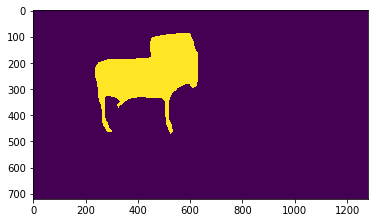

In [7]:
if CONNECT_CAM:
    bed_color_path = SAVE_DIR + '/bed.jpg'
    bed_depth_path = SAVE_DIR + '/bed.png'
else:
    bed_color_path = EXP_IMG_DIR + '/513.jpg'
    bed_depth_path = EXP_IMG_DIR + '/513.png'

# bed_color_path = "scripts/milestone_202110/save_img/526.jpg"
# bed_depth_path = "scripts/milestone_202110/save_img/526.png"

# Read color, depth image file, keep 16bit information
color_img_read = cv2.imread(bed_color_path, flags=cv2.IMREAD_UNCHANGED)
depth_img_read = cv2.imread(bed_depth_path, flags=cv2.IMREAD_UNCHANGED)


# Output of inference(mask for detected table)
mask_out = detect_from_server(color_img_read)

if mask_out is not None:
    plt.imshow(mask_out)
    
    # Crop masking part
    vis_mask = (mask_out * 255).astype('uint8')
    color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
    depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
    cv2.imwrite(CROP_DIR + '/bed_crop.jpg', color_instance)
    cv2.imwrite(CROP_DIR + '/bed_crop.png', depth_instance)
    
#     set_cam_params(cam_intrins, d_scale)
    ICP_result_bed = process_bed_detection()

In [8]:
T_toff = np.identity(4)
T_toff[:3,:3] = np.array([[0,1,0],[0,0,1],[1,0,0]])
T_toff[:3,3] = np.array([0.455,0,1.05])

T_co = np.matmul(ICP_result_bed, T_toff)
T_bc = viewpoint.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))
T_bo = np.matmul(T_bc, T_co)

In [9]:
bed_center = T_bo[:3,3]
bed_rpy = Rot2rpy(T_bo[:3,:3])

# bed_center = (2,0,0)
# bed_rpy = (0,0,np.pi/2)
COLOR_BED_COL = (0,1,0,0.3)

bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

In [10]:
T_revis = np.identity(4)
T_revis[:3,:3] = Rot_axis(3, Rot2axis(bed_mat.get_tf(VIEW_POSE_EXT)[:3,:3],3))
bed_rpy = Rot2rpy(T_revis[:3,:3])

# adjust
bed_center[2]=0
if Rot_rpy(bed_rpy)[0,0] > 0:
    bed_rpy[2] += np.pi

bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

#### 1.1.3  move to closet side

In [11]:
bed_vis = gscene.NAME_DICT["bed_vis"]
T_bo = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

In [12]:
if CONNECT_CAM:
    color_path = SAVE_DIR + '/bed.jpg'
    depth_path = SAVE_DIR + '/bed.png'
else:
    color_path = EXP_IMG_DIR + '/513.jpg'
    depth_path = EXP_IMG_DIR + '/513.png'

# Determine the location of closet
CLOSET_LOCATION = check_location_top_table(color_path, depth_path, T_bc, T_bo, bed_dims=bed_mat.dims, 
                                           visualize=False)
print("CLOSET on {}".format(CLOSET_LOCATION))

T_bm_from = wayframer.get_tf_handle(list2dict(VIEW_POSE_EXT, gscene.joint_names))
T_bs = bed_mat.get_tf(VIEW_POSE_EXT)

if CLOSET_LOCATION == "LEFT":
    T_sm = SE3(Rot_axis(3, np.pi), [1.5, -1.4, 0])
elif CLOSET_LOCATION == "RIGHT":       
    T_sm = SE3(Rot_axis(3, np.pi), [1.5, 1.4, 0])
    
T_bm = np.matmul(T_bs, T_sm)

x,y = T_bm[:2,3]
theta = Rot2axis(T_bm[:3,:3], 3)
VIEW_MOVED_EXT = np.add(VIEW_POSE_EXT, [x,y,theta]+[0]*9) 
gscene.show_pose(VIEW_MOVED_EXT)

CLOSET on LEFT


In [13]:
T_shift = np.matmul(SE3_inv(T_bm_from), T_bm)
cur_xyzw, tar_xyzw_rd, tar_xyzw = get_relative_mobile_command(T_shift, CONNECT_MOBILE)
cur_xyzw = move_mobile_robot(sock_mobile, cur_xyzw, tar_xyzw, tar_xyzw, MOBILE_IP, CONNECT_MOBILE)

curre  xyzw: [ 0.49  1.39 -0.65  0.76]
ready  xyzw: [ 3.27 -0.45 -0.7   0.71]
target xyzw: [ 3.27 -0.95 -0.7   0.71]
move to: [ 3.27 -0.95 -0.7   0.71]
(3.2692742633841245, -0.9536393595635348, -0.7045987209510747, 0.709605976887251, 0)
move to: [ 3.27 -0.95 -0.7   0.71]
(3.2692742633841245, -0.9536393595635348, -0.7045987209510747, 0.709605976887251, 0)


#### 1.1.4  detect and add closet

#### 1.1.4.1 reconstruct moving camera 

In [14]:
import threading
global STOP_THREADS

## for camera streaming in a thread
class CaptureThread:
    def __init__(self):
        self.stop_flag = False
        
    def __call__(self):
        i = 0
        self.clear_files()
        print("Start streaming")
        while not self.stop_flag:
            rdict = stream_capture_image(ImageType.CloseView, i, host=CAM_HOST)
            i += 1
        print("Stop streaming")
    def clear_files(self):
        cfiles = os.listdir(COLOR_PATH)
        for cfile in cfiles:
            os.remove(os.path.join(COLOR_PATH, cfile))
        dfiles = os.listdir(DEPTH_PATH)
        for dfile in dfiles:
            os.remove(os.path.join(DEPTH_PATH, dfile))

In [15]:
capture_fn = CaptureThread()
stream_thread = threading.Thread(target=capture_fn)

In [16]:
if CONNECT_CAM:
    try:
        stream_thread.start()
        if CONNECT_INDY:
            time.sleep(1)
            VIEW_POSE_UP = np.deg2rad([0, -50, 70, 0, 60, -180])
            VIEW_DIFF = np.subtract(VIEW_POSE_UP, VIEW_POSE)
            VIEW_SPEED = 1
            N_SCAN = 20
            with indy:
                vel_level_bak = indy.get_joint_vel_level()
                indy.set_joint_vel_level(VIEW_SPEED)

                for i in range(N_SCAN+1):
                    indy.joint_move_to(np.rad2deg(np.add(VIEW_POSE, VIEW_DIFF/N_SCAN*i)))
                    indy.wait_motion()
                for i in range(N_SCAN+1):
                    indy.joint_move_to(np.rad2deg(np.subtract(VIEW_POSE_UP, VIEW_DIFF/N_SCAN*i)))
                    indy.wait_motion()

                indy.set_joint_vel_level(vel_level_bak)
        else:
            time.sleep(5)
        time.sleep(0.5)
    finally:
        capture_fn.stop_flag = True

Start streaming
Connect: Server IP (192.168.0.3)


In [17]:
if not CONNECT_CAM:
    COLOR_PATH = EXP_IMG_DIR + "/top_table/color"
    DEPTH_PATH = EXP_IMG_DIR + "/top_table/depth"
    INTRINSIC_PATH = EXP_IMG_DIR + "/top_table"

save_intrinsic_as_json(INTRINSIC_PATH + "/intrinsic.json")
INTRINSIC_FILE = INTRINSIC_PATH + "/intrinsic.json"

In [18]:
from boost_reconstruction.reconstruction_interface import reconstruction_interface_py as rci
rci.getReconstruction(COLOR_PATH, DEPTH_PATH, INTRINSIC_FILE, MILESTONE_DIR)

'========= Complete 3D Reconstruction ========='

In [19]:
Qdict_scan = list2dict(VIEW_MOVED_EXT, gscene.joint_names)
T_bc = viewpoint.get_tf(Qdict_scan)
T_bs = bed_vis.get_tf(Qdict_scan)
T_sc = np.matmul(SE3_inv(T_bs), T_bc)

ICP_result_top_table = process_top_table_detection(T_sc=T_sc, bed_dims=bed_mat.dims, z_ceiling = 2.3,
                                                   initial_offset=[0.3,1.1,0.6], floor_margin=0.1, 
                                                   visualize=False)

T_toff = np.identity(4)
T_toff[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
T_toff[:3,3] = np.array([0.3,0,0.2725])

T_co = np.matmul(ICP_result_top_table, T_toff)
T_bc = viewpoint.get_tf(list2dict(VIEW_MOVED_EXT, gscene.joint_names))
T_bo = np.matmul(T_bc, T_co)

T_co = np.matmul(ICP_result_top_table, T_toff)
T_bc = viewpoint.get_tf(list2dict(VIEW_MOVED_EXT, gscene.joint_names))
T_bo = np.matmul(T_bc, T_co)
T_bo[:3,:3] = Rot_axis(3, Rot2axis(T_bo[:3,:3], 3))
T_bo[2,3] = 0

if CONNECT_CAM:
    # Add closet based on ICP result
    closet_left, closet_rightup, closet_rightdown = add_closet(
        gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
        COLOR_CLOSET_COL=(0,1,0,0.3))
else:
    closet_left, closet_rightup, closet_rightdown = add_closet(
    gscene, closet_center=np.matmul(Rot_rpy(bed_rpy), (-0.75,-1,0))+bed_center, closet_rpy=bed_rpy, 
    COLOR_CLOSET_COL=(0,1,0,0.3))

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.300.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.300.
Apply point-to-point ICP
registration::RegistrationResult with fitness=2.154902e-01, inlier_rmse=3.346780e-02, and correspondence_set size of 1099
Access transformation to get result.
Transformation is:
[[-0.09320848 -0.04165469 -0.99477488  0.82670001]
 [ 0.36442904 -0.93121854  0.00484707  0.81659611]
 [-0.92655472 -0.36207307  0.10197764  2.70847283]
 [ 0.          0.          0.          1.        ]]


### 1.2 Make bed cleaning plan

#### 1.2.1 get division-base pose combination data

In [20]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *

Stop streaming


In [21]:
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

wp_task, wp_hdl = add_waypoint_task(pscene, "waypoint", WP_DIMS, (0,0,0), (0,0,0), 
                                    parent="floor_ws", color=(0, 0, 1, 0.5))
ccheck = CachedCollisionCheck(gcheck, wp_task, wp_hdl, wayframer)

In [22]:
BED_OFFSET = 0.05
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(-gscene.NAME_DICT['brush_face'].dims[0]/2-CLEARANCE-BED_OFFSET,0,0), 
                                  rpy=(0,np.pi/2*1,0))

T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]

In [23]:
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, sqdiv_size, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(bed_mat, brush_face, robot_config, 
                                          plane_val=EE_HEIGHT, tip_dir=None, TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck)

#### 1.2.2 select coering base poses and generate motions

In [24]:
HOME_POSE_MOVE = VIEW_POSE
HOME_POSE_SWEEP = VIEW_POSE_EXT
HOME_POSE_SWEEP[6:] = HOME_POSE_MOVE
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    
test_fun = TestBaseDivFunc(ppline, floor_ws, bed_mat, sqdiv_size, WP_DIMS, TOOL_DIM, crob.home_dict)

In [25]:
test_fun.clear()

idx_bases, idc_divs, covered_all, snode_schedule_dict = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step,
    test_fun=test_fun)

Use 36/36 agents
======================= terminated 10: max iteration time reached (1633520635/1633520632.84 s) ===============================
======================= terminated 0: max iteration time reached (1633520635/1633520632.84 s) ===============================
======================= terminated 2: max iteration time reached (1633520635/1633520632.84 s) ===============================
======================= terminated 12: max iteration time reached (1633520635/1633520632.84 s) ===============================
======================= terminated 26: max iteration time reached (1633520635/1633520632.84 s) ===============================
======================= terminated 7: max iteration time reached (1633520635/1633520632.84 s) ===============================
======================= terminated 23: max iteration time reached (1633520635/1633520632.84 s) ===============================
======================= terminated 29: max iteration time reached (1633520635/1633520632.84 s) ==

======================= terminated 33: max iteration time reached (1633520635/1633520632.84 s) ===============================
======================= terminated 18: max iteration time reached (1633520635/1633520632.84 s) ===============================
======================= terminated 31: max iteration time reached (1633520636/1633520632.84 s) ===============================
======================= terminated 32: max iteration time reached (1633520636/1633520632.84 s) ===============================
======================= terminated 1: max iteration time reached (1633520636/1633520632.84 s) ===============================
======================= terminated 14: max iteration time reached (1633520636/1633520632.84 s) ===============================
======================= terminated 20: max iteration time reached (1633520636/1633520632.84 s) ===============================
======================= terminated 19: max iteration time reached (1633520636/1633520632.84 s) =================

======================= terminated 4: first answer acquired from other agent ===============================
======================= terminated 6: first answer acquired from other agent ===============================
======================= terminated 27: first answer acquired from other agent ===============================
======================= terminated 19: first answer acquired from other agent ===============================
======================= terminated 29: first answer acquired from other agent ===============================
======================= terminated 28: first answer acquired from other agent ===============================
======================= terminated 30: first answer acquired from other agent ===============================
======================= terminated 7: first answer acquired from other agent ===============================
======================= terminated 8: first answer acquired from other agent ===============================
==============

======================= terminated 15: first answer acquired from other agent ===============================
======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 28: first answer acquired from other agent ===============================
======================= terminated 11: first answer acquired from other agent ===============================
======================= terminated 20: first answer acquired from other agent ===============================
======================= terminated 27: first answer acquired from other agent ===============================
======================= terminated 16: first answer acquired from other agent ===============================
======================= terminated 34: first answer acquired from other agent ===============================
======================= terminated 4: first answer acquired from other agent ===============================
===========

======================= terminated 1: first answer acquired from other agent ===============================
======================= terminated 24: first answer acquired from other agent ===============================
======================= terminated 3: first answer acquired from other agent ===============================
======================= terminated 18: first answer acquired from other agent ===============================
Goal reached
======================= terminated 22: first answer acquired ===============================
======================= terminated 31: first answer acquired from other agent ===============================
======================= terminated 32: first answer acquired from other agent ===============================
Use 36/36 agents
Goal reached
Goal reached
======================= terminated 0: first answer acquired ===============================
======================= terminated 1: first answer acquired ===============================
=========

======================= terminated 16: first answer acquired from other agent ===============================
======================= terminated 12: first answer acquired from other agent ===============================
======================= terminated 31: first answer acquired from other agent ===============================
======================= terminated 17: first answer acquired from other agent ===============================
======================= terminated 2: first answer acquired from other agent ===============================
======================= terminated 23: first answer acquired from other agent ===============================
======================= terminated 32: first answer acquired from other agent ===============================
======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 21: first answer acquired from other agent ===============================
===========

======================= terminated 4: first answer acquired from other agent ===============================
======================= terminated 15: first answer acquired from other agent ===============================
======================= terminated 1: first answer acquired from other agent ===============================
======================= terminated 14: first answer acquired from other agent ===============================
======================= terminated 25: first answer acquired from other agent ===============================
======================= terminated 5: first answer acquired from other agent ===============================
======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 35: first answer acquired from other agent ===============================
======================= terminated 18: first answer acquired from other agent ===============================
=============

======================= terminated 13: first answer acquired ===============================
======================= terminated 16: first answer acquired ===============================
Use 36/36 agents
Goal reached
======================= terminated 6: first answer acquired ===============================
======================= terminated 12: first answer acquired from other agent ===============================
======================= terminated 30: first answer acquired from other agent ===============================
Goal reached
======================= terminated 4: first answer acquired from other agent ===============================
======================= terminated 29: first answer acquired from other agent ===============================
======================= terminated 9: first answer acquired ===============================
======================= terminated 5: first answer acquired from other agent ===============================
======================= terminated 10: 

======================= terminated 17: first answer acquired from other agent ===============================
======================= terminated 27: first answer acquired from other agent ===============================
======================= terminated 2: first answer acquired from other agent ===============================
======================= terminated 35: first answer acquired from other agent ===============================
======================= terminated 26: first answer acquired from other agent ===============================
======================= terminated 13: first answer acquired from other agent ===============================
======================= terminated 1: first answer acquired from other agent ===============================
======================= terminated 7: first answer acquired from other agent ===============================
======================= terminated 21: first answer acquired from other agent ===============================
Goal reached


======================= terminated 23: first answer acquired from other agent ===============================
======================= terminated 27: first answer acquired from other agent ===============================
Goal reached
======================= terminated 24: first answer acquired from other agent ===============================
======================= terminated 13: first answer acquired ===============================
Goal reached
======================= terminated 28: first answer acquired from other agent ===============================
======================= terminated 8: first answer acquired ===============================
======================= terminated 25: first answer acquired from other agent ===============================
======================= terminated 32: first answer acquired from other agent ===============================
======================= terminated 21: first answer acquired from other agent ===============================
===================

======================= terminated 17: first answer acquired from other agent ===============================
======================= terminated 18: first answer acquired from other agent ===============================
======================= terminated 4: first answer acquired from other agent ===============================
======================= terminated 6: first answer acquired from other agent ===============================
======================= terminated 9: first answer acquired from other agent ===============================
======================= terminated 21: first answer acquired from other agent ===============================
======================= terminated 19: first answer acquired from other agent ===============================
======================= terminated 1: first answer acquired from other agent ===============================
======================= terminated 0: first answer acquired from other agent ===============================
===============

======================= terminated 31: first answer acquired from other agent ===============================
======================= terminated 32: first answer acquired from other agent ===============================
======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 34: first answer acquired from other agent ===============================
======================= terminated 35: first answer acquired from other agent ===============================
Use 36/36 agents
======================= terminated 2: max iteration time reached (1633520656/1633520653.36 s) ===============================
======================= terminated 32: max iteration time reached (1633520656/1633520653.36 s) ===============================
======================= terminated 18: max iteration time reached (1633520656/1633520653.36 s) ===============================
======================= terminated 26: max iteration 

======================= terminated 33: max iteration time reached (1633520656/1633520653.36 s) ===============================
======================= terminated 16: max iteration time reached (1633520656/1633520653.36 s) ===============================
======================= terminated 12: max iteration time reached (1633520656/1633520653.36 s) ===============================
======================= terminated 21: max iteration time reached (1633520656/1633520653.36 s) ===============================
======================= terminated 25: max iteration time reached (1633520656/1633520653.36 s) ===============================
======================= terminated 20: max iteration time reached (1633520656/1633520653.36 s) ===============================
======================= terminated 34: max iteration time reached (1633520656/1633520653.36 s) ===============================
======================= terminated 23: max iteration time reached (1633520656/1633520653.36 s) ================

======================= terminated 9: first answer acquired from other agent ===============================
======================= terminated 3: first answer acquired from other agent ===============================
======================= terminated 15: first answer acquired from other agent ===============================
======================= terminated 24: first answer acquired from other agent ===============================
======================= terminated 16: first answer acquired from other agent ===============================
======================= terminated 19: first answer acquired from other agent ===============================
======================= terminated 26: first answer acquired from other agent ===============================
Goal reached
======================= terminated 17: first answer acquired from other agent ===============================
======================= terminated 18: first answer acquired from other agent ===============================

======================= terminated 35: first answer acquired from other agent ===============================
Use 36/36 agents
======================= terminated 19: max iteration time reached (1633520662/1633520659.67 s) ===============================
======================= terminated 9: max iteration time reached (1633520662/1633520659.67 s) ===============================
======================= terminated 22: max iteration time reached (1633520662/1633520659.67 s) ===============================
======================= terminated 13: max iteration time reached (1633520662/1633520659.67 s) ===============================
======================= terminated 20: max iteration time reached (1633520662/1633520659.67 s) ===============================
======================= terminated 7: max iteration time reached (1633520662/1633520659.67 s) ===============================
======================= terminated 26: max iteration time reached (1633520662/1633520659.67 s) ==================

======================= terminated 34: max iteration time reached (1633520662/1633520659.67 s) ===============================
======================= terminated 33: max iteration time reached (1633520662/1633520659.67 s) ===============================
======================= terminated 10: max iteration time reached (1633520662/1633520659.67 s) ===============================
======================= terminated 1: max iteration time reached (1633520662/1633520659.67 s) ===============================
======================= terminated 27: max iteration time reached (1633520662/1633520659.67 s) ===============================
======================= terminated 3: max iteration time reached (1633520662/1633520659.67 s) ===============================
======================= terminated 29: max iteration time reached (1633520662/1633520659.67 s) ===============================
======================= terminated 30: max iteration time reached (1633520662/1633520659.67 s) ==================

======================= terminated 20: first answer acquired from other agent ===============================
Goal reached
======================= terminated 10: first answer acquired from other agent ===============================
======================= terminated 22: first answer acquired from other agent ===============================
======================= terminated 9: first answer acquired ===============================
======================= terminated 21: first answer acquired from other agent ===============================
Goal reached
Goal reached
Goal reached
======================= terminated 8: first answer acquired ===============================
======================= terminated 23: first answer acquired from other agent ===============================
======================= terminated 11: first answer acquired ===============================
======================= terminated 13: first answer acquired ===============================
======================= term

#### 1.2.3 refine motions

In [26]:
snode_schedule_list, scene_args_list, scene_kwargs_list = refine_order_plan(
    ppline, snode_schedule_dict, idx_bases, idc_divs, VIEW_MOVED_EXT, 
    floor_ws, wayframer, bed_mat, Tsm_keys, surface_div_centers, sqdiv_size, 
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


### 1.3 Execute bed cleaning sequence

In [27]:
# CONNECT_INDY = False
# CONNECT_MOBILE = False

In [30]:
indy.traj_vel = 3
swp_fin_list = []
i_s, (snode_schedule, sargs, skwargs) = \
    list(enumerate(zip(snode_schedule_list, \
                       scene_args_list, scene_kwargs_list)))[0]
set_base_sweep(*sargs, **skwargs)

In [31]:
snode_pre, snode_nxt = \
    zip(snode_schedule[:-1], snode_schedule[1:])[0]
snode_pre = snode_pre.copy(pscene)
snode_pre.traj = None
from_state = snode_pre.state
to_state = snode_nxt.state
subjects, ok = pscene.get_changing_subjects(from_state, to_state)

if len(subjects) ==0 or subjects[0] == "sweep":
    if CONNECT_INDY:
        ppline.execute_schedule([snode_pre, snode_nxt], 
                                one_by_one=True)
        with indy:
            time.sleep(0.5)
            indy.wait_for_move_finish()
    else:
        ppline.play_schedule([snode_pre, snode_nxt], period=0.002)

elif subjects[0] == "waypoints":
    Tbw0 = wayframer.get_tf_handle(list2dict(from_state.Q, 
                                             gscene.joint_names))
    Tbw1 = wayframer.get_tf_handle(list2dict(to_state.Q, 
                                             gscene.joint_names))
    Tw0w1 = np.matmul(SE3_inv(Tbw0), Tbw1)
    cur_xyzw, tar_xyzw_rd, tar_xyzw = get_relative_mobile_command(
        Tw0w1, CONNECT_MOBILE)
    if CONNECT_MOBILE:
        cur_xyzw = move_mobile_robot(sock_mobile, 
                                     cur_xyzw, tar_xyzw_rd, tar_xyzw, 
                                     MOBILE_IP, CONNECT_MOBILE)
    else:
        gscene.show_motion(snode_nxt.traj)
    gscene.show_pose(to_state.Q)

curre  xyzw: [ 3.25 -0.92 -0.72  0.7 ]
ready  xyzw: [ 3.7  -2.15  1.    0.01]
target xyzw: [ 3.2  -2.14  1.    0.01]
move to: [ 3.7  -2.15  1.    0.01]
(3.7015796248394226, -2.15176174216865, 0.9999215880435355, 0.012522378109548968, 0)
move to: [ 3.2  -2.14  1.    0.01]
(3.2017364603826177, -2.139240343984988, 0.9999215880435355, 0.012522378109548968, 0)


In [125]:
Q_bak = to_Q

In [129]:
from_Q = np.copy(Q_bak)
to_Q = np.copy(from_Q)

In [130]:
to_Q[0]+=0.2
to_Q[1]-=0.2

In [131]:
gscene.show_pose(to_Q)

In [132]:

Tbw0 = wayframer.get_tf_handle(list2dict(from_Q, 
                                         gscene.joint_names))
Tbw1 = wayframer.get_tf_handle(list2dict(to_Q, 
                                         gscene.joint_names))
Tw0w1 = np.matmul(SE3_inv(Tbw0), Tbw1)
cur_xyzw, tar_xyzw_rd, tar_xyzw = get_relative_mobile_command(
    Tw0w1, CONNECT_MOBILE)
if CONNECT_MOBILE:
    cur_xyzw = move_mobile_robot(sock_mobile, 
                                 cur_xyzw, tar_xyzw_rd, tar_xyzw, 
                                 MOBILE_IP, CONNECT_MOBILE)

curre  xyzw: [ 3.23 -1.86 -0.72  0.69]
ready  xyzw: [ 3.07 -1.58  0.72 -0.69]
target xyzw: [ 3.05 -2.08  0.72 -0.69]
move to: [ 3.07 -1.58  0.72 -0.69]
(3.069965061688586, -1.581359334379889, 0.720631365576615, -0.6933184224778562, 0)
move to: [ 3.05 -2.08  0.72 -0.69]
(3.0506555017545227, -2.0809863310247856, 0.720631365576615, -0.6933184224778562, 0)


In [133]:
Qview = [   0.,  -50.,   70.,   0,   90., -180.]
fullQ = np.copy(to_Q)
fullQ[6:] = np.deg2rad(Qview)
gscene.show_pose(fullQ)
with indy:
    indy.joint_move_to(Qview)

Connect: Server IP (192.168.0.3)


In [134]:
rdict = stream_capture_image(ImageType.FirstView, 0, host=CAM_HOST)

In [136]:
T_rc = closet_vis.get_tf(fullQ, from_link=ROBOT_BASE)

In [137]:
data_dict = {"Q": Qview, "T_robot_closet": T_rb, "image_dict": rdict}

In [138]:
save_pickle(os.path.join(SAVE_DIR, "closet_close.pkl"), data_dict)

In [135]:
closet_vis = gscene.NAME_DICT["closet_vis"]

In [ ]:
# leave highlight on cleared area
swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
gscene.update_marker(swp_fin)
swp_fin_list.append(swp_fin)

In [32]:
CONNECT_MOBILE = True

In [34]:
Tbw0 = wayframer.get_tf_handle(list2dict(from_state.Q, gscene.joint_names))
Tbw1 = wayframer.get_tf_handle(list2dict(to_state.Q, gscene.joint_names))
Tw0w1 = np.matmul(SE3_inv(Tbw0), Tbw1)
cur_xyzw, tar_xyzw_rd, tar_xyzw = get_relative_mobile_command(Tw0w1, CONNECT_MOBILE)

curre  xyzw: [ 3.43 -1.01 -0.75  0.66]
ready  xyzw: [ 3.32 -2.28  1.    0.06]
target xyzw: [ 2.82 -2.22  1.    0.06]


In [35]:
cur_xyzw = move_mobile_robot(sock_mobile, cur_xyzw, tar_xyzw, tar_xyzw, MOBILE_IP, CONNECT_MOBILE)

move to: [ 2.82 -2.22  1.    0.06]
(2.8189833833046776, -2.2229929466449, 0.9982569314952748, 0.05901535133922182, 0)


KeyboardInterrupt: 

In [48]:
gscene.show_pose(from_state.Q)

In [50]:
tar_xyzw

array([ 1.34886537e+00, -4.40915343e-01, -5.15589027e-05,  9.99999881e-01])

In [ ]:

# leave highlight on cleared area
swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
gscene.update_marker(swp_fin)
swp_fin_list.append(swp_fin)

In [31]:
indy.traj_vel = 3
swp_fin_list = []
for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    set_base_sweep(*sargs, **skwargs)
    for snode_pre, snode_nxt in zip(snode_schedule[:-1], snode_schedule[1:]):
        from_state = snode_pre.state
        to_state = snode_nxt.state
        subjects, ok = pscene.get_changing_subjects(from_state, to_state)

        if len(subjects) ==0 or subjects[0] == "sweep":
            if CONNECT_INDY:
                ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
                with indy:
                    time.sleep(0.5)
                    indy.wait_for_move_finish()
            else:
                ppline.play_schedule([snode_pre, snode_nxt], period=0.002)

        elif subjects[0] == "waypoints":
            Tbw0 = wayframer.get_tf_handle(list2dict(from_state.Q, gscene.joint_names))
            Tbw1 = wayframer.get_tf_handle(list2dict(to_state.Q, gscene.joint_names))
            Tw0w1 = np.matmul(SE3_inv(Tbw0), Tbw1)
            cur_xyzw, tar_xyzw_rd, tar_xyzw = get_relative_mobile_command(Tw0w1, CONNECT_MOBILE)
            if CONNECT_MOBILE:
                cur_xyzw = move_mobile_robot(sock_mobile, cur_xyzw, tar_xyzw, tar_xyzw, MOBILE_IP, CONNECT_MOBILE, move_direct=True)
            else:
                gscene.show_motion(snode_nxt.traj)
            gscene.show_pose(to_state.Q)
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)

curre  xyzw: [0 0 0 1]
ready  xyzw: [ 0.85 -0.44 -0.    1.  ]
target xyzw: [ 1.35 -0.44 -0.    1.  ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.49 -0.1   0.    1.  ]
target xyzw: [ 0.01 -0.09  0.    1.  ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.07  0.51  0.71 -0.71]
target xyzw: [-0.07  0.01  0.71 -0.71]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.57  0.07  0.    1.  ]
target xyzw: [-0.07  0.07  0.    1.  ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
curre  xyzw: [0 0 0 1]
ready  xyzw: [2.34 0.02 1.   0.  ]
target xyzw: [1.84 0.02 1.   0.  ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.55 -0.35  0.    1.  ]
target xyzw: [-0.05 -0.35  0.    1.  ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.81  0.   -0.    1.  ]
target xyzw: [-0.31  0.   -0.    1.  ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(

In [ ]:
test_fun.clear()
for swp_fin in swp_fin_list:
    gscene.remove(swp_fin)


## 2. Closet cleaning

### 2.1. Detect closet

### 2.2. Make closet cleaning plan

#### 2.2.1 get division-base pose combination data

In [ ]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *

In [ ]:
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(-gscene.NAME_DICT['brush_face'].dims[0]/2-CLEARANCE,0,0), 
                                  rpy=(0,np.pi/2*1,0))
ccheck.clear()

In [ ]:
div_base_dict, Tsm_keys, surface_div_centers, sqdiv_size, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(closet_left, brush_face, robot_config,
                                          plane_val=None, tip_dir="up", TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck)

In [ ]:
# def get_division_dict(surface, brush_face, robot_config, plane_val, tip_dir, TOOL_DIM, ccheck):
surface, brush_face, robot_config, plane_val, tip_dir, TOOL_DIM, ccheck = closet_left, brush_face, robot_config, None, "up", TOOL_DIM, ccheck
## get data
rtype = robot_config.type.name
sweep_path = os.path.join(SWEEP_DAT_PATH, rtype if tip_dir is None else "{}-{}".format(rtype, tip_dir))
sweep_max = np.loadtxt(sweep_path+"-max.csv", delimiter=",")
sweep_min = np.loadtxt(sweep_path+"-min.csv", delimiter=",")

gcheck = ccheck.gcheck
pscene = gcheck.pscene
gscene = pscene.gscene
crob = pscene.combined_robot

## divide surface with squares
sqdiv_size_ref = np.max(TOOL_DIM)
surf_offset = 0.05
surface_dim_eff = np.subtract(surface.dims[:2],
                              sqdiv_size_ref)  # effective surface dims - except tool dimension to boundaries
div_close = np.ceil(surface_dim_eff[0] / sqdiv_size_ref).astype(np.int)
sqdiv_size = surface_dim_eff[0] / div_close  # reduce square size to fit the closed ends
div_num_ = np.ceil(surface_dim_eff / sqdiv_size).astype(np.int)
surface_dim_eff = np.round(sqdiv_size * div_num_, 5)  # enpand effective size of open ends
div_num = div_num_ + 1
surface_div_centers = [tuple(np.round(-surface_dim_eff / 2 + np.multiply(sqdiv_size, (i, j)), 5))
                       for i, j in product(range(div_num[0]), range(div_num[1]))]

#### 2.2.2 Generate cleaning sweep motions

## 3. Return to home